In [14]:
from PIL import Image
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
import tensorflow.keras as keras

In [15]:
def convert_to_gray(image):
    image = np.array(image)
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
        return gray_image
    else:
        return image

def load_data(fold_num):
    # 資料夾路徑
    base_path = f"/content/drive/MyDrive/Colab Notebooks/Fold{fold_num}"
    # 資料類型
    types = ['train', 'val', 'test']
    # 初始化存儲列表
    fold = {
        'train': {'image': [], 'mask': [], 'image_file_name': [], 'mask_file_name': []},
        'val': {'image': [], 'mask': [], 'image_file_name': [], 'mask_file_name': []},
        'test': {'image': [], 'mask': [], 'image_file_name': [], 'mask_file_name': []}
    }
    # 載入數據
    for t in types:
        image_dir = os.path.join(base_path, t)
        mask_dir = os.path.join(base_path, t + 'annot')
        image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]
        mask_files = [os.path.join(mask_dir, f) for f in os.listdir(mask_dir)]

        # 讀取圖像和遮罩
        for img_file, mask_file in zip(image_files, mask_files):
            img = Image.open(img_file)
            mask = Image.open(mask_file)
            # 儲存檔案名稱
            fold[t]['image_file_name'].append(os.path.basename(img_file))
            fold[t]['mask_file_name'].append(os.path.basename(mask_file))
            fold[t]['image'].append(img)
            fold[t]['mask'].append(mask)
    return fold

# fold1 = load_data(1)

# print("Number of images in test folder:", len(fold1['test']['image']))
# print("Number of images in testannot folder:", len(fold1['test']['mask']))
# print("Number of images in train folder:", len(fold1['train']['image']))
# print("Number of images in trainannot folder:", len(fold1['train']['mask']))
# print("Number of images in val folder:", len(fold1['val']['image']))
# print("Number of images in valannot folder:", len(fold1['val']['mask']))

In [16]:
# # 檢查訓練數據的形狀
# for image, mask in train_image.take(1):
#     print("訓練圖像的形狀:", image.shape)
#     print("訓練遮罩的形狀:", mask.shape)

# # 檢查驗證數據的形狀
# for image, mask in val_dataset.take(1):
#     print("驗證圖像的形狀:", image.shape)
#     print("驗證遮罩的形狀:", mask.shape)


In [17]:
# plt.subplot(1,2,1)
# plt.imshow(fold1['train']['image'][1], cmap="gray")
# plt.title(f' Image\n{fold1["train"]["image_file_name"][1]}')
# plt.axis('off')
# plt.subplot(1,2,2)
# plt.imshow(fold1['train']['mask'][1])
# plt.title(f' Image\n{fold1["train"]["mask_file_name"][1]}')
# plt.axis('off')
# plt.show()

In [18]:
class Augmentation:

    def __init__(self, configs) -> None:
        self.configs = configs
        self.choice = None

    def crop_and_resize(img, mask, size=(256, 256)):
        img = np.array(img)
        mask = np.array(mask)
        # crop to square
        h, w = img.shape[:2]
        if h > w:
            img = img[:w, :]
            mask = mask[:w, :]
        else:
            w_center = w // 2
            img = img[:, w_center - h // 2: (w_center - h // 2)+h]
            mask = mask[:, w_center - h // 2: (w_center - h // 2)+h]

        # resize to 256x256
        img = cv2.resize(img, size)
        mask = cv2.resize(mask, size)

        img = Image.fromarray(img)
        mask = Image.fromarray(mask)

        return img, mask

    def crop_and_resize2(img, mask, size=(256, 256)):
        # 獲取圖像的高度和寬度
        h, w = img.shape[:2]

        # 計算裁剪的起始位置
        start_h = (h - min(h, w)) // 2
        start_w = (w - min(h, w)) // 2

        # 根據裁剪的起始位置裁剪圖像和遮罩
        img_cropped = img[start_h:start_h + min(h, w), start_w:start_w + min(h, w)]
        mask_cropped = mask[start_h:start_h + min(h, w), start_w:start_w + min(h, w)]

        # 將裁剪後的圖像和遮罩調整為指定的大小
        img_resized = cv2.resize(img_cropped, size)
        mask_resized = cv2.resize(mask_cropped, size)

        return img_resized, mask_resized

    def crop_and_resize3(img, mask, size=(256, 256)):
        img = tf.convert_to_tensor(img)
        mask = tf.convert_to_tensor(mask)

        h, w = tf.shape(img)[0], tf.shape(img)[1]

        if h > w:
            img = img[:w, :]
            mask = mask[:w, :]
        else:
            w_center = w // 2
            img = img[:, w_center - h // 2: w_center + h // 2, :]
            mask = mask[:, w_center - h // 2: w_center + h // 2, :]

        img = tf.image.resize(img, size)
        mask = tf.image.resize(mask, size)

        return img, mask


    def crop_and_resize4(image, mask, size=(256, 256)):
        """
        此函數接收圖像及其對應遮罩的PIL圖像對象，並通過調整至期望尺寸進行預處理，同時確保遮罩不被裁剪。

        :param image_obj: 圖像的PIL圖像對象
        :param mask_obj: 遮罩的PIL圖像對象
        :param desired_size: 一個元組，表示期望的尺寸 (寬度, 高度)
        :return: 處理後的 (圖像, 遮罩) 對象元組
        """
        # 確保遮罩不被裁剪，集中裁剪框在遮罩周圍
        mask_bounds = mask.getbbox()  # 獲取遮罩非零區域的邊界框
        if mask_bounds:
            # 計算遮罩的中心點
            mask_center = ((mask_bounds[0] + mask_bounds[2]) // 2, (mask_bounds[1] + mask_bounds[3]) // 2)
            # 確定裁剪框的大小
            crop_half_size = min(mask_center[0], mask_center[1], image.width - mask_center[0], image.height - mask_center[1])
            # 使裁剪框為正方形
            crop_box = (mask_center[0] - crop_half_size, mask_center[1] - crop_half_size,
                        mask_center[0] + crop_half_size, mask_center[1] + crop_half_size)
            # 圍繞遮罩裁剪圖像
            image = image.crop(crop_box)
            mask = mask.crop(crop_box)

        # 將圖像和遮罩調整至期望尺寸
        image = image.resize(size,  Image.Resampling.LANCZOS)
        mask = mask.resize(size, Image.Resampling.LANCZOS)

        return image, mask

    def img_normalize(img, mask):

        img = np.array(img)
        mask = np.array(mask)

        img = img / 255

        binary_mask = mask.copy()
        binary_mask[mask > 128] = 1
        binary_mask[mask <= 128] = 0

        img = img.astype(np.float32)
        binary_mask = binary_mask.astype(np.float32)

        return img, binary_mask

    def apply_horizontal_flip(self, image, mask):
        combined_tensor = tf.concat([image, mask], axis=2)
        combined_tensor = tf.image.random_flip_left_right(
            combined_tensor, seed=self.configs['seed']
        )
        image, mask = tf.split(
            combined_tensor,
            [self.configs['image_channels'], self.configs['label_channels']], axis=2
        )
        return image, mask

    def apply_horizontal_flip2(image_obj, mask_obj, angle_range=(-15, 15)):
        """
        對圖像及其對應的遮罩進行隨機旋轉。

        :param image_obj: 圖像的PIL圖像對象
        :param mask_obj: 遮罩的PIL圖像對象
        :param angle_range: 旋轉角度範圍，一個包含最小和最大角度的元組
        :return: 旋轉後的 (圖像, 遮罩) 對象元組
        """
        # 隨機生成旋轉角度
        angle = random.uniform(angle_range[0], angle_range[1])

        # 對圖像進行旋轉
        rotated_image = image_obj.rotate(angle, resample=Image.BICUBIC)

        # 對遮罩進行旋轉
        rotated_mask = mask_obj.rotate(angle, resample=Image.NEAREST)

        return rotated_image, rotated_mask

In [19]:
# print(Augmentation.crop_and_resize(fold1['train']['image'][1], fold1['train']['mask'][1]))

In [20]:
def preprocess_all_images_and_masks(fold, size=(256, 256)):
    """
    修改前面定義的函數來避免 AttributeError。
    """
    # 遍歷每個類型的數據集 (train, val, test)
    for t in fold.keys():
        # 遍歷每個圖像和遮罩對象
        for i in range(len(fold[t]['image'])):
            # 使用新的預處理函數來處理已經載入的圖像和遮罩對象
            preprocessed_img, preprocessed_mask = Augmentation.crop_and_resize(
                fold[t]['image'][i],fold[t]['mask'][i], size)

            # 替換數據字典中的圖像和遮罩對象為預處理後的版本
            fold[t]['image'][i] = preprocessed_img
            fold[t]['mask'][i]= preprocessed_mask

    return fold

In [21]:
# fold1_preprocess = preprocess_all_images_and_masks(fold1)

# plt.subplot(1,2,1)
# plt.imshow(fold1_preprocess['train']['image'][1], cmap="gray")
# plt.title(f' Image\n{fold1_preprocess["train"]["image_file_name"][1]}')
# plt.axis('off')
# plt.subplot(1,2,2)
# plt.imshow(fold1_preprocess['train']['mask'][1])
# plt.title(f' Image\n{fold1_preprocess["train"]["mask_file_name"][1]}')
# plt.axis('off')
# plt.show()

In [22]:
configs = {
    'seed': 42,  # 隨機種子
    'image_channels': 3,  # 圖像通道數
    'label_channels': 1  # 遮罩通道數
}

def augment_data(fold, num_augmented_samples_per_image=5):
    """
    對給定的資料集進行資料擴增，對訓練集中的每個圖像及其對應的遮罩進行隨機旋轉，並將擴增後的圖像和遮罩添加到訓練資料集中。

    :param data: 包含訓練、驗證和測試資料的字典
    :param num_augmented_samples_per_image: 每個原始圖像擴增的數量
    :return: 擴增後的資料字典
    """
    # 初始化存儲擴增後圖像和遮罩的列表
    augmented_images = []
    augmented_masks = []

    # 對訓練集進行擴增
    for i in range(len(fold['train']['image'])):
        # 對每個原始圖像進行指定數量的隨機旋轉
        for _ in range(num_augmented_samples_per_image):
            # 隨機旋轉圖像和遮罩
            rotated_img, rotated_mask = Augmentation.apply_horizontal_flip2(fold['train']['image'][i], fold['train']['mask'][i])

            # 添加擴增後的圖像和遮罩到列表中
            augmented_images.append(rotated_img)
            augmented_masks.append(rotated_mask)

    # 將擴增後的圖像和遮罩列表添加到訓練資料集中
    fold['train']['image'].extend(augmented_images)
    fold['train']['mask'].extend(augmented_masks)

    return fold

In [23]:
# fold1_augmented = augment_data(fold1_preprocess)

In [24]:
# plt.subplot(1,2,1)
# plt.imshow(fold1_augmented['train']['image'][288], cmap="gray")
# plt.title(f' Image\n{fold1_augmented["train"]["image_file_name"][1]}')
# plt.axis('off')
# plt.subplot(1,2,2)
# plt.imshow(fold1_augmented['train']['mask'][288])
# plt.title(f' Image\n{fold1_augmented["train"]["mask_file_name"][1]}')
# plt.axis('off')
# plt.show()

In [25]:
# CLAHE強化
# def apply_clahe(image):
#     image = np.array(image)
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
#     lab_planes = cv2.split(lab)
#     lab_planes[0] = clahe.apply(lab_planes[0])
#     lab = cv2.merge(lab_planes)
#     return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

# # 資料前處理和強化
# def preprocess_images(images, masks):
#     preprocessed_images = [apply_clahe(image) for image in images]
#     return np.array(preprocessed_images), np.array(masks)

# # 處理訓練資料
# train_images_preprocessed, train_masks_preprocessed = preprocess_images(train_images, train_masks)

# # 處理驗證資料
# val_images_preprocessed, val_masks_preprocessed = preprocess_images(val_images, val_masks)

# # 顯示原始圖像和強化後的圖像
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.cvtColor(train_images[0], cv2.COLOR_BGR2RGB))
# plt.title("Original Image")
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(cv2.cvtColor(train_images_preprocessed[0], cv2.COLOR_BGR2RGB))
# plt.title("CLAHE Enhanced Image")
# plt.axis('off')

# plt.show()

#-----------------------------------------------------------------------------------------------------------------
# 對資料進行預處理
'''
CLAHE是一種強化醫學影像中對比度的技術，特別適用於改善X射線影像中的結構可視性，
從而提高分割的準確性和可靠性(Ikhsan et al., 2014)。　　https://ieeexplore.ieee.org/document/6805749
'''
## 創建CLAHE方法
def enhance_contrast(image):

    # 將PIL圖像轉換為NumPy陣列
    gray_image_array = np.array(image.convert('L'))

    # 創建CLAHE對象
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

    # 對灰度影像進行CLAHE處理
    enhanced_image_array = clahe.apply(gray_image_array)

    enhanced_image = Image.fromarray(enhanced_image_array, 'L')
    return enhanced_image


## 創建批次處理方法
def batch_contrast_enhancement(fold):
    # 遍歷所有資料集類型（train、val、test）
    for t in fold.keys():
        # 遍歷每個資料集類型中的所有圖像
        for i in range(len(fold[t]['image'])):
            # 對每張圖像進行對比度增強
            enhanced_image = enhance_contrast(fold[t]['image'][i])
            # 更新圖像列表中的圖像
            fold[t]['image'][i] = enhanced_image

    return fold


In [26]:
# clahe_fold1 = batch_contrast_enhancement(fold1_augmented)

In [27]:
# plt.subplot(1,2,1)
# plt.imshow(clahe_fold1['train']['image'][288], cmap="gray")
# plt.title(f' Image\n{clahe_fold1["train"]["image_file_name"][1]}')
# plt.axis('off')
# plt.subplot(1,2,2)
# plt.imshow(clahe_fold1['train']['mask'][288])
# plt.title(f' Image\n{clahe_fold1["train"]["mask_file_name"][1]}')
# plt.axis('off')
# plt.show()

In [28]:
def normalization(fold):
    # 遍歷所有資料集類型（train、val、test）
    for t in fold.keys():
        # 遍歷每個資料集類型中的所有圖像
        for i in range(len(fold[t]['image'])):
            # 對每張圖像進行正規化
            normalization_image, normalization_mask = Augmentation.img_normalize(fold[t]['image'][i], fold[t]['mask'][i])
            # 更新圖像列表中的圖像
            fold[t]['image'][i] = normalization_image
            fold[t]['mask'][i] = normalization_mask

    return fold

In [29]:
# nor_fold1 = normalization(clahe_fold1)

# plt.subplot(1,2,1)
# plt.imshow(nor_fold1['train']['image'][1], cmap="gray")
# plt.axis('off')
# plt.subplot(1,2,2)
# plt.imshow(nor_fold1['train']['mask'][1])
# plt.axis('off')
# plt.show()

In [30]:
# # step 1 .讀取圖像資料(同時載入image與mask)
# fold1 = load_data(1)
# fold2 = load_data(2)
# fold3 = load_data(3)
# fold4 = load_data(4)
# fold5 = load_data(5)

# for i in fold1.keys():
#     for t in range(len(fold1[i]['image'])):
#         fold1[i]['image'][t] = convert_to_gray(fold1[i]['image'][t])
#         fold1[i]['mask'][t] = convert_to_gray(fold1[i]['mask'][t])

# for i in fold2.keys():
#     for t in range(len(fold2[i]['image'])):
#         fold2[i]['image'][t] = convert_to_gray(fold2[i]['image'][t])
#         fold2[i]['mask'][t] = convert_to_gray(fold2[i]['mask'][t])

# for i in fold3.keys():
#     for t in range(len(fold3[i]['image'])):
#         fold3[i]['image'][t] = convert_to_gray(fold3[i]['image'][t])
#         fold3[i]['mask'][t] = convert_to_gray(fold3[i]['mask'][t])

# for i in fold4.keys():
#     for t in range(len(fold4[i]['image'])):
#         fold4[i]['image'][t] = convert_to_gray(fold4[i]['image'][t])
#         fold4[i]['mask'][t] = convert_to_gray(fold4[i]['mask'][t])

# for i in fold5.keys():
#     for t in range(len(fold5[i]['image'])):
#         fold5[i]['image'][t] = convert_to_gray(fold5[i]['image'][t])
#         fold5[i]['mask'][t] = convert_to_gray(fold5[i]['mask'][t])

# fold1_preprocess = preprocess_all_images_and_masks(fold1)
# fold2_preprocess = preprocess_all_images_and_masks(fold2)
# fold3_preprocess = preprocess_all_images_and_masks(fold3)
# fold4_preprocess = preprocess_all_images_and_masks(fold4)
# fold5_preprocess = preprocess_all_images_and_masks(fold5)

# fold1_augmented = augment_data(fold1_preprocess)
# fold2_augmented = augment_data(fold2_preprocess)
# fold3_augmented = augment_data(fold3_preprocess)
# fold4_augmented = augment_data(fold4_preprocess)
# fold5_augmented = augment_data(fold5_preprocess)

# clahe_fold1 = batch_contrast_enhancement(fold1_augmented)
# clahe_fold2 = batch_contrast_enhancement(fold2_augmented)
# clahe_fold3 = batch_contrast_enhancement(fold3_augmented)
# clahe_fold4 = batch_contrast_enhancement(fold4_augmented)
# clahe_fold5 = batch_contrast_enhancement(fold5_augmented)

# nor_fold1 = normalization(clahe_fold1)
# nor_fold2 = normalization(clahe_fold2)
# nor_fold3 = normalization(clahe_fold3)
# nor_fold4 = normalization(clahe_fold4)
# nor_fold5 = normalization(clahe_fold5)

In [31]:
def iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / union

def iou_ccalculate(y_true, y_pred, pixels_per_cm=72):
    absolute_difference = tf.abs(y_true - y_pred)

    mean_error = tf.reduce_mean(absolute_difference) / pixels_per_cm
    accuracy_within_50mm = tf.reduce_mean(tf.cast(absolute_difference <= (pixels_per_cm / 2), tf.float32)) * 100
    accuracy_within_1cm = tf.reduce_mean(tf.cast(absolute_difference <= pixels_per_cm, tf.float32)) * 100

    return mean_error, accuracy_within_50mm, accuracy_within_1cm

def to_binary_mask(mask):
    max_value = np.max(mask)
    binary_mask = mask.copy()
    binary_mask[mask > max_value/2] = 1
    binary_mask[mask <= max_value/2] = 0
    return binary_mask

In [32]:
# # 檢查訓練數據的形狀
# # for image, mask in zip(nor_fold1['train']['image'], nor_fold1['train']['mask']):
# #     print("訓練圖像的形狀:", image.shape)
# #     print("訓練遮罩的形狀:", mask.shape)
# print(train_mask.shape)
# print(train_image.shape)
# print("訓練圖像的形狀:", nor_fold1['train']['image'][1].shape)
# # train_image1 = np.expand_dims(nor_fold1['train']['image'][1], axis=-1)
# # print("訓練圖像的形狀:", train_image1.shape)
# print("訓練遮罩的形狀:", nor_fold1['train']['mask'][1].shape)
# print("驗證圖像的形狀:", nor_fold1['val']['image'][1].shape)
# print("驗證遮罩的形狀:", nor_fold1['val']['mask'][1].shape)

In [33]:
import tensorflow as tf
from tensorflow.keras import layers

class ResizeLayer(layers.Layer):
    def __init__(self, target_size, **kwargs):
        super(ResizeLayer, self).__init__(**kwargs)
        self.target_size = target_size

    def call(self, inputs):
        return tf.image.resize(inputs, self.target_size)

# 定义模型
def create_deeplab_model_with_mobilenet(input_shape=(256, 256, 1), num_classes=1):
    base_model = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3), include_top=False)
    base_model.layers.pop()
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Concatenate(axis=-1)([inputs] * 3)
    x = base_model(x, training=False)
    up_stack = [
        layers.UpSampling2D(size=(2, 2)),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.UpSampling2D(size=(2, 2)),
        layers.Conv2D(16, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
    ]
    x = inputs
    for up in up_stack:
        x = up(x)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)
    outputs = ResizeLayer((256, 256))(outputs)  # 使用自定义的调整大小层

    return tf.keras.Model(inputs=inputs, outputs=outputs)

model = create_deeplab_model_with_mobilenet()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 up_sampling2d (UpSampling2  (None, 512, 512, 1)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 512, 512, 32)      128       
 Normalization)                                                  
                                                                 
 up_sampling2d_1 (UpSamplin  (None, 1024, 1024, 32)    0         
 g2D)                                                            
                                                             

In [26]:
# step 1 .讀取圖像資料(同時載入image與mask)
fold1 = load_data(1)

for i in fold1.keys():
    for t in range(len(fold1[i]['image'])):
        fold1[i]['image'][t] = convert_to_gray(fold1[i]['image'][t])
        fold1[i]['mask'][t] = convert_to_gray(fold1[i]['mask'][t])

fold1_preprocess = preprocess_all_images_and_masks(fold1)

fold1_augmented = augment_data(fold1_preprocess)

clahe_fold1 = batch_contrast_enhancement(fold1_augmented)

nor_fold1 = normalization(clahe_fold1)


In [28]:
# 處理數據
train_image = nor_fold1['train']['image']
train_mask = nor_fold1['train']['mask']
val_image = nor_fold1['val']['image']
val_mask = nor_fold1['val']['mask']

# train_image = np.expand_dims(train_image, axis=-1)
# train_mask = np.expand_dims(train_mask, axis=-1)
# val_image = np.expand_dims(val_image, axis=-1)
# val_mask = np.expand_dims(val_mask, axis=-1)

input_shape = (256, 256, 1)
num_classes = 1  # 將類別數更改為 1，因為是二元分類
batch_size = 16
epochs = 10

# 創建訓練和驗證數據集
train_dataset = tf.data.Dataset.from_tensor_slices((train_image, train_mask)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_image, val_mask)).batch(batch_size)

# 創建並編譯模型
model = create_deeplab_model_with_mobilenet(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 訓練模型
history = model.fit(train_dataset,
          epochs=epochs,
          validation_data=val_dataset)



Epoch 1/10


ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/model_2/conv2d_7/Conv2D/Conv2DBackpropInput defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-28-06bc820d3a91>", line 28, in <cell line: 28>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 543, in minimize

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients

OOM when allocating tensor with shape[16,64,1024,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model_2/conv2d_7/Conv2D/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_15918]

In [ ]:
test_images = nor_fold1['test']['image']
test_masks = nor_fold1['test']['mask']

test_images = np.expand_dims(test_images, axis=-1)
test_masks = np.expand_dims(test_masks, axis=-1)

# 对测试图像进行预测
predictions = model.predict(test_images, batch_size=batch_size, verbose=0)

# 初始化性能指标列表
mean_error_list = []
accuracy_within_50mm_list = []
accuracy_within_1cm_list = []
iou_list = []  # 新添加的列表用于存储 IOU

# 遍历测试图像，计算性能指标和 IOU
for i in range(len(test_images)):
    # 获取当前图像的预测结果和真实标签
    pred_mask = predictions[i]
    true_mask = test_masks[i]

    # 将预测结果转换为二进制掩码
    pred_binary_mask = to_binary_mask(pred_mask)

    # 计算 IOU
    iou_score = iou(true_mask, pred_binary_mask)

    # 计算性能指标
    mean_error, accuracy_within_50mm, accuracy_within_1cm = iou_ccalculate(true_mask, pred_binary_mask)

    # 将计算结果添加到性能指标列表中
    mean_error_list.append(mean_error)
    accuracy_within_50mm_list.append(accuracy_within_50mm)
    accuracy_within_1cm_list.append(accuracy_within_1cm)
    iou_list.append(iou_score)  # 将 IOU 添加到列表中

# 计算平均性能指标和平均 IOU
mean_error_avg = np.mean(mean_error_list)
accuracy_within_50mm_avg = np.mean(accuracy_within_50mm_list)
accuracy_within_1cm_avg = np.mean(accuracy_within_1cm_list)
iou_avg = np.mean(iou_list)  # 计算平均 IOU

# 打印平均性能指标和平均 IOU
print(f'Mean Error: {mean_error_avg:.10f}')
print(f'Accuracy within 50mm: {accuracy_within_50mm_avg}%')
print(f'Accuracy within 1cm: {accuracy_within_1cm_avg}%')
print(f'Mean IOU: {iou_avg:.10f}')


In [ ]:
pre_mask = model.predict(test_masks[:1])
binary_mask = to_binary_mask(pre_mask[0])
plt.subplot(2, 3, 1)
plt.imshow(test_images[0].reshape(256, 256), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 2)
plt.imshow(test_masks[0].reshape(256, 256), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 3)
plt.imshow(binary_mask.reshape(256, 256), cmap='gray')
plt.axis('off')

pre_mask = model.predict(test_images[1:2])
binary_mask = to_binary_mask(pre_mask[0])
plt.subplot(2, 3, 4)
plt.imshow(test_images[1].reshape(256, 256), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 5)
plt.imshow(test_masks[1].reshape(256, 256), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 6)
plt.imshow(binary_mask.reshape(256, 256), cmap='gray')
plt.axis('off')

Epoch 1/10
108/108 [==============================] - 106s 756ms/step - loss: 0.3318 - accuracy: 0.9275 - val_loss: 0.4987 - val_accuracy: 0.9912
Epoch 2/10
108/108 [==============================] - 61s 560ms/step - loss: 0.0776 - accuracy: 0.9886 - val_loss: 0.3375 - val_accuracy: 0.9912
Epoch 3/10
108/108 [==============================] - 59s 550ms/step - loss: 0.0635 - accuracy: 0.9886 - val_loss: 0.2649 - val_accuracy: 0.9884
Epoch 4/10
108/108 [==============================] - 59s 551ms/step - loss: 0.0622 - accuracy: 0.9886 - val_loss: 0.1971 - val_accuracy: 0.9821
Epoch 5/10
108/108 [==============================] - 60s 552ms/step - loss: 0.0617 - accuracy: 0.9886 - val_loss: 0.1160 - val_accuracy: 0.9908
Epoch 6/10
108/108 [==============================] - 59s 551ms/step - loss: 0.0615 - accuracy: 0.9886 - val_loss: 0.0682 - val_accuracy: 0.9912
Epoch 7/10
108/108 [==============================] - 60s 558ms/step - loss: 0.0613 - accuracy: 0.9886 - val_loss: 0.0541 - val_a

(-0.5, 255.5, 255.5, -0.5)

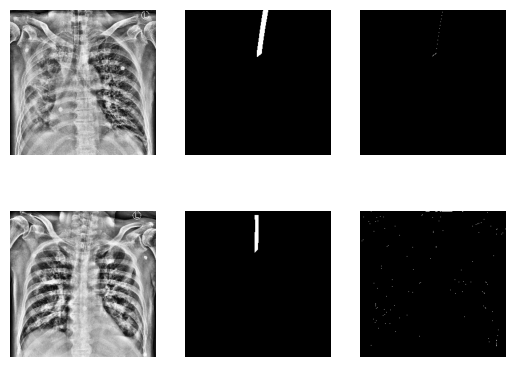

In [30]:
#FOLD2
# step 1 .讀取圖像資料(同時載入image與mask)
fold2 = load_data(2)

for i in fold2.keys():
    for t in range(len(fold2[i]['image'])):
        fold2[i]['image'][t] = convert_to_gray(fold2[i]['image'][t])
        fold2[i]['mask'][t] = convert_to_gray(fold2[i]['mask'][t])

fold2_preprocess = preprocess_all_images_and_masks(fold2)

fold2_augmented = augment_data(fold2_preprocess)

clahe_fold2 = batch_contrast_enhancement(fold2_augmented)

nor_fold2 = normalization(clahe_fold2)

# 處理數據
train_image = nor_fold2['train']['image']
train_mask = nor_fold2['train']['mask']
val_image = nor_fold2['val']['image']
val_mask = nor_fold2['val']['mask']

input_shape = (256, 256, 1)
num_classes = 1  # 將類別數更改為 1，因為是二元分類
batch_size = 16
epochs = 10

# 創建訓練和驗證數據集
train_dataset = tf.data.Dataset.from_tensor_slices((train_image, train_mask)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_image, val_mask)).batch(batch_size)

# 創建並編譯模型
model = create_deeplab_model_with_mobilenet(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 訓練模型
history = model.fit(train_dataset,
          epochs=epochs,
          validation_data=val_dataset)

test_images = nor_fold2['test']['image']
test_masks = nor_fold2['test']['mask']

test_images = np.expand_dims(test_images, axis=-1)
test_masks = np.expand_dims(test_masks, axis=-1)

# 对测试图像进行预测
predictions = model.predict(test_images, batch_size=batch_size, verbose=0)

# 初始化性能指标列表
mean_error_list = []
accuracy_within_50mm_list = []
accuracy_within_1cm_list = []
iou_list = []  # 新添加的列表用于存储 IOU

# 遍历测试图像，计算性能指标和 IOU
for i in range(len(test_images)):
    # 获取当前图像的预测结果和真实标签
    pred_mask = predictions[i]
    true_mask = test_masks[i]

    # 将预测结果转换为二进制掩码
    pred_binary_mask = to_binary_mask(pred_mask)

    # 计算 IOU
    iou_score = iou(true_mask, pred_binary_mask)

    # 计算性能指标
    mean_error, accuracy_within_50mm, accuracy_within_1cm = iou_ccalculate(true_mask, pred_binary_mask)

    # 将计算结果添加到性能指标列表中
    mean_error_list.append(mean_error)
    accuracy_within_50mm_list.append(accuracy_within_50mm)
    accuracy_within_1cm_list.append(accuracy_within_1cm)
    iou_list.append(iou_score)  # 将 IOU 添加到列表中

# 计算平均性能指标和平均 IOU
mean_error_avg = np.mean(mean_error_list)
accuracy_within_50mm_avg = np.mean(accuracy_within_50mm_list)
accuracy_within_1cm_avg = np.mean(accuracy_within_1cm_list)
iou_avg = np.mean(iou_list)  # 计算平均 IOU

# 打印平均性能指标和平均 IOU
print(f'Mean Error: {mean_error_avg:.10f}')
print(f'Accuracy within 50mm: {accuracy_within_50mm_avg}%')
print(f'Accuracy within 1cm: {accuracy_within_1cm_avg}%')
print(f'Mean IOU: {iou_avg:.10f}')

pre_mask = model.predict(test_masks[:1])
binary_mask = to_binary_mask(pre_mask[0])
plt.subplot(2, 3, 1)
plt.imshow(test_images[0].reshape(256, 256), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 2)
plt.imshow(test_masks[0].reshape(256, 256), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 3)
plt.imshow(binary_mask.reshape(256, 256), cmap='gray')
plt.axis('off')

pre_mask = model.predict(test_images[1:2])
binary_mask = to_binary_mask(pre_mask[0])
plt.subplot(2, 3, 4)
plt.imshow(test_images[1].reshape(256, 256), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 5)
plt.imshow(test_masks[1].reshape(256, 256), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 6)
plt.imshow(binary_mask.reshape(256, 256), cmap='gray')
plt.axis('off')


Epoch 1/10
108/108 [==============================] - 100s 711ms/step - loss: 0.2710 - accuracy: 0.9426 - val_loss: 0.4586 - val_accuracy: 0.9901
Epoch 2/10
108/108 [==============================] - 60s 555ms/step - loss: 0.0681 - accuracy: 0.9886 - val_loss: 0.3734 - val_accuracy: 0.9901
Epoch 3/10
108/108 [==============================] - 60s 554ms/step - loss: 0.0628 - accuracy: 0.9886 - val_loss: 0.3346 - val_accuracy: 0.9848
Epoch 4/10
108/108 [==============================] - 59s 549ms/step - loss: 0.0618 - accuracy: 0.9886 - val_loss: 0.2538 - val_accuracy: 0.9767
Epoch 5/10
108/108 [==============================] - 59s 550ms/step - loss: 0.0616 - accuracy: 0.9886 - val_loss: 0.1275 - val_accuracy: 0.9901
Epoch 6/10
108/108 [==============================] - 59s 549ms/step - loss: 0.0614 - accuracy: 0.9886 - val_loss: 0.0750 - val_accuracy: 0.9901
Epoch 7/10
108/108 [==============================] - 60s 555ms/step - loss: 0.0613 - accuracy: 0.9886 - val_loss: 0.0578 - val_a

(-0.5, 255.5, 255.5, -0.5)

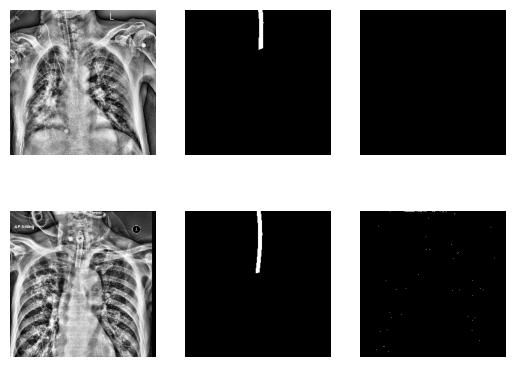

In [34]:
# step 1 .讀取圖像資料(同時載入image與mask)
fold3 = load_data(3)

for i in fold3.keys():
    for t in range(len(fold3[i]['image'])):
        fold3[i]['image'][t] = convert_to_gray(fold3[i]['image'][t])
        fold3[i]['mask'][t] = convert_to_gray(fold3[i]['mask'][t])

fold3_preprocess = preprocess_all_images_and_masks(fold3)

fold3_augmented = augment_data(fold3_preprocess)

clahe_fold3 = batch_contrast_enhancement(fold3_augmented)

nor_fold3 = normalization(clahe_fold3)

# 處理數據
train_image = nor_fold3['train']['image']
train_mask = nor_fold3['train']['mask']
val_image = nor_fold3['val']['image']
val_mask = nor_fold3['val']['mask']

input_shape = (256, 256, 1)
num_classes = 1  # 將類別數更改為 1，因為是二元分類
batch_size = 16
epochs = 10

# 創建訓練和驗證數據集
train_dataset = tf.data.Dataset.from_tensor_slices((train_image, train_mask)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_image, val_mask)).batch(batch_size)

# 創建並編譯模型
model = create_deeplab_model_with_mobilenet(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 訓練模型
history = model.fit(train_dataset,
          epochs=epochs,
          validation_data=val_dataset)

test_images = nor_fold3['test']['image']
test_masks = nor_fold3['test']['mask']

test_images = np.expand_dims(test_images, axis=-1)
test_masks = np.expand_dims(test_masks, axis=-1)

# 对测试图像进行预测
predictions = model.predict(test_images, batch_size=batch_size, verbose=0)

# 初始化性能指标列表
mean_error_list = []
accuracy_within_50mm_list = []
accuracy_within_1cm_list = []
iou_list = []  # 新添加的列表用于存储 IOU

# 遍历测试图像，计算性能指标和 IOU
for i in range(len(test_images)):
    # 获取当前图像的预测结果和真实标签
    pred_mask = predictions[i]
    true_mask = test_masks[i]

    # 将预测结果转换为二进制掩码
    pred_binary_mask = to_binary_mask(pred_mask)

    # 计算 IOU
    iou_score = iou(true_mask, pred_binary_mask)

    # 计算性能指标
    mean_error, accuracy_within_50mm, accuracy_within_1cm = iou_ccalculate(true_mask, pred_binary_mask)

    # 将计算结果添加到性能指标列表中
    mean_error_list.append(mean_error)
    accuracy_within_50mm_list.append(accuracy_within_50mm)
    accuracy_within_1cm_list.append(accuracy_within_1cm)
    iou_list.append(iou_score)  # 将 IOU 添加到列表中

# 计算平均性能指标和平均 IOU
mean_error_avg = np.mean(mean_error_list)
accuracy_within_50mm_avg = np.mean(accuracy_within_50mm_list)
accuracy_within_1cm_avg = np.mean(accuracy_within_1cm_list)
iou_avg = np.mean(iou_list)  # 计算平均 IOU

# 打印平均性能指标和平均 IOU
print(f'Mean Error: {mean_error_avg:.10f}')
print(f'Accuracy within 50mm: {accuracy_within_50mm_avg}%')
print(f'Accuracy within 1cm: {accuracy_within_1cm_avg}%')
print(f'Mean IOU: {iou_avg:.10f}')

pre_mask = model.predict(test_masks[:1])
binary_mask = to_binary_mask(pre_mask[0])
plt.subplot(2, 3, 1)
plt.imshow(test_images[0].reshape(256, 256), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 2)
plt.imshow(test_masks[0].reshape(256, 256), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 3)
plt.imshow(binary_mask.reshape(256, 256), cmap='gray')
plt.axis('off')

pre_mask = model.predict(test_images[1:2])
binary_mask = to_binary_mask(pre_mask[0])
plt.subplot(2, 3, 4)
plt.imshow(test_images[1].reshape(256, 256), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 5)
plt.imshow(test_masks[1].reshape(256, 256), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 6)
plt.imshow(binary_mask.reshape(256, 256), cmap='gray')
plt.axis('off')


Epoch 1/10
107/107 [==============================] - 76s 701ms/step - loss: 0.2729 - accuracy: 0.9134 - val_loss: 0.5001 - val_accuracy: 0.9903
Epoch 2/10
107/107 [==============================] - 59s 550ms/step - loss: 0.0641 - accuracy: 0.9888 - val_loss: 0.4336 - val_accuracy: 0.9903
Epoch 3/10
107/107 [==============================] - 59s 550ms/step - loss: 0.0629 - accuracy: 0.9888 - val_loss: 0.2906 - val_accuracy: 0.9903
Epoch 4/10
107/107 [==============================] - 59s 551ms/step - loss: 0.0621 - accuracy: 0.9888 - val_loss: 0.2053 - val_accuracy: 0.9903
Epoch 5/10
107/107 [==============================] - 59s 550ms/step - loss: 0.0616 - accuracy: 0.9888 - val_loss: 0.1045 - val_accuracy: 0.9903
Epoch 6/10
107/107 [==============================] - 59s 552ms/step - loss: 0.0614 - accuracy: 0.9888 - val_loss: 0.0827 - val_accuracy: 0.9903
Epoch 7/10
107/107 [==============================] - 60s 556ms/step - loss: 0.0612 - accuracy: 0.9888 - val_loss: 0.0548 - val_ac

(-0.5, 255.5, 255.5, -0.5)

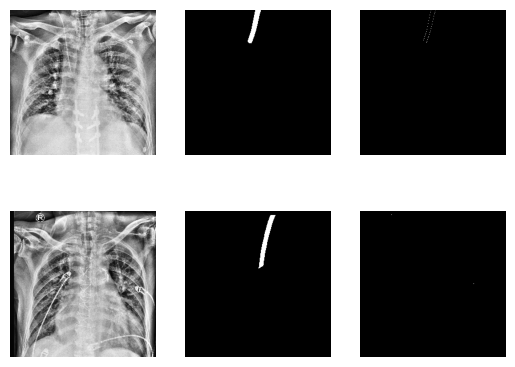

In [35]:
del fold3
del fold3_preprocess
del fold3_augmented
del clahe_fold3
del nor_fold3
del train_image
del train_mask
del val_image
del val_mask
del test_images
del test_masks
# step 1 .讀取圖像資料(同時載入image與mask)
fold4 = load_data(4)

for i in fold4.keys():
    for t in range(len(fold4[i]['image'])):
        fold4[i]['image'][t] = convert_to_gray(fold4[i]['image'][t])
        fold4[i]['mask'][t] = convert_to_gray(fold4[i]['mask'][t])

fold4_preprocess = preprocess_all_images_and_masks(fold4)

fold4_augmented = augment_data(fold4_preprocess)

clahe_fold4 = batch_contrast_enhancement(fold4_augmented)

nor_fold4 = normalization(clahe_fold4)

# 處理數據
train_image = nor_fold4['train']['image']
train_mask = nor_fold4['train']['mask']
val_image = nor_fold4['val']['image']
val_mask = nor_fold4['val']['mask']

input_shape = (256, 256, 1)
num_classes = 1  # 將類別數更改為 1，因為是二元分類
batch_size = 16
epochs = 10

# 創建訓練和驗證數據集
train_dataset = tf.data.Dataset.from_tensor_slices((train_image, train_mask)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_image, val_mask)).batch(batch_size)

# 創建並編譯模型
model = create_deeplab_model_with_mobilenet(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 訓練模型
history = model.fit(train_dataset,
          epochs=epochs,
          validation_data=val_dataset)

test_images = nor_fold4['test']['image']
test_masks = nor_fold4['test']['mask']

test_images = np.expand_dims(test_images, axis=-1)
test_masks = np.expand_dims(test_masks, axis=-1)

# 对测试图像进行预测
predictions = model.predict(test_images, batch_size=batch_size, verbose=0)

# 初始化性能指标列表
mean_error_list = []
accuracy_within_50mm_list = []
accuracy_within_1cm_list = []
iou_list = []  # 新添加的列表用于存储 IOU

# 遍历测试图像，计算性能指标和 IOU
for i in range(len(test_images)):
    # 获取当前图像的预测结果和真实标签
    pred_mask = predictions[i]
    true_mask = test_masks[i]

    # 将预测结果转换为二进制掩码
    pred_binary_mask = to_binary_mask(pred_mask)

    # 计算 IOU
    iou_score = iou(true_mask, pred_binary_mask)

    # 计算性能指标
    mean_error, accuracy_within_50mm, accuracy_within_1cm = iou_ccalculate(true_mask, pred_binary_mask)

    # 将计算结果添加到性能指标列表中
    mean_error_list.append(mean_error)
    accuracy_within_50mm_list.append(accuracy_within_50mm)
    accuracy_within_1cm_list.append(accuracy_within_1cm)
    iou_list.append(iou_score)  # 将 IOU 添加到列表中

# 计算平均性能指标和平均 IOU
mean_error_avg = np.mean(mean_error_list)
accuracy_within_50mm_avg = np.mean(accuracy_within_50mm_list)
accuracy_within_1cm_avg = np.mean(accuracy_within_1cm_list)
iou_avg = np.mean(iou_list)  # 计算平均 IOU

# 打印平均性能指标和平均 IOU
print(f'Mean Error: {mean_error_avg:.10f}')
print(f'Accuracy within 50mm: {accuracy_within_50mm_avg}%')
print(f'Accuracy within 1cm: {accuracy_within_1cm_avg}%')
print(f'Mean IOU: {iou_avg:.10f}')

pre_mask = model.predict(test_masks[:1])
binary_mask = to_binary_mask(pre_mask[0])
plt.subplot(2, 3, 1)
plt.imshow(test_images[0].reshape(256, 256), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 2)
plt.imshow(test_masks[0].reshape(256, 256), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 3)
plt.imshow(binary_mask.reshape(256, 256), cmap='gray')
plt.axis('off')

pre_mask = model.predict(test_images[1:2])
binary_mask = to_binary_mask(pre_mask[0])
plt.subplot(2, 3, 4)
plt.imshow(test_images[1].reshape(256, 256), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 5)
plt.imshow(test_masks[1].reshape(256, 256), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 6)
plt.imshow(binary_mask.reshape(256, 256), cmap='gray')
plt.axis('off')


Epoch 1/10
107/107 [==============================] - 61s 555ms/step - loss: 0.2338 - accuracy: 0.9549 - val_loss: 0.4801 - val_accuracy: 0.9909
Epoch 2/10
107/107 [==============================] - 59s 551ms/step - loss: 0.0667 - accuracy: 0.9886 - val_loss: 0.3419 - val_accuracy: 0.9909
Epoch 3/10
107/107 [==============================] - 59s 550ms/step - loss: 0.0626 - accuracy: 0.9886 - val_loss: 0.2285 - val_accuracy: 0.9909
Epoch 4/10
107/107 [==============================] - 59s 551ms/step - loss: 0.0623 - accuracy: 0.9886 - val_loss: 0.1117 - val_accuracy: 0.9909
Epoch 5/10
107/107 [==============================] - 59s 555ms/step - loss: 0.0621 - accuracy: 0.9886 - val_loss: 0.0738 - val_accuracy: 0.9909
Epoch 6/10
107/107 [==============================] - 59s 548ms/step - loss: 0.0620 - accuracy: 0.9886 - val_loss: 0.0536 - val_accuracy: 0.9909
Epoch 7/10
107/107 [==============================] - 59s 550ms/step - loss: 0.0619 - accuracy: 0.9886 - val_loss: 0.0540 - val_ac

Mean Error: 0.0001405168
Accuracy within 50mm: 100.0%
Accuracy within 1cm: 100.0%
Mean IOU: 0.0010967469
1/1 [==============================] - 0s 17ms/step


(-0.5, 255.5, 255.5, -0.5)

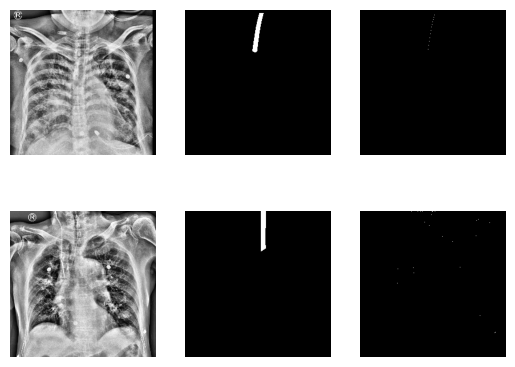

In [36]:
del fold4
del fold4_preprocess
del fold4_augmented
del clahe_fold4
del nor_fold4
del train_image
del train_mask
del val_image
del val_mask
del test_images
del test_masks
# step 1 .讀取圖像資料(同時載入image與mask)
fold5 = load_data(5)

for i in fold5.keys():
    for t in range(len(fold5[i]['image'])):
        fold5[i]['image'][t] = convert_to_gray(fold5[i]['image'][t])
        fold5[i]['mask'][t] = convert_to_gray(fold5[i]['mask'][t])

fold5_preprocess = preprocess_all_images_and_masks(fold5)

fold5_augmented = augment_data(fold5_preprocess)

clahe_fold5 = batch_contrast_enhancement(fold5_augmented)

nor_fold5 = normalization(clahe_fold5)

# 處理數據
train_image = nor_fold5['train']['image']
train_mask = nor_fold5['train']['mask']
val_image = nor_fold5['val']['image']
val_mask = nor_fold5['val']['mask']

input_shape = (256, 256, 1)
num_classes = 1  # 將類別數更改為 1，因為是二元分類
batch_size = 16
epochs = 10

# 創建訓練和驗證數據集
train_dataset = tf.data.Dataset.from_tensor_slices((train_image, train_mask)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_image, val_mask)).batch(batch_size)

# 創建並編譯模型
model = create_deeplab_model_with_mobilenet(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 訓練模型
history = model.fit(train_dataset,
          epochs=epochs,
          validation_data=val_dataset)

test_images = nor_fold5['test']['image']
test_masks = nor_fold5['test']['mask']

test_images = np.expand_dims(test_images, axis=-1)
test_masks = np.expand_dims(test_masks, axis=-1)

# 对测试图像进行预测
predictions = model.predict(test_images, batch_size=batch_size, verbose=0)

# 初始化性能指标列表
mean_error_list = []
accuracy_within_50mm_list = []
accuracy_within_1cm_list = []
iou_list = []  # 新添加的列表用于存储 IOU

# 遍历测试图像，计算性能指标和 IOU
for i in range(len(test_images)):
    # 获取当前图像的预测结果和真实标签
    pred_mask = predictions[i]
    true_mask = test_masks[i]

    # 将预测结果转换为二进制掩码
    pred_binary_mask = to_binary_mask(pred_mask)

    # 计算 IOU
    iou_score = iou(true_mask, pred_binary_mask)

    # 计算性能指标
    mean_error, accuracy_within_50mm, accuracy_within_1cm = iou_ccalculate(true_mask, pred_binary_mask)

    # 将计算结果添加到性能指标列表中
    mean_error_list.append(mean_error)
    accuracy_within_50mm_list.append(accuracy_within_50mm)
    accuracy_within_1cm_list.append(accuracy_within_1cm)
    iou_list.append(iou_score)  # 将 IOU 添加到列表中

# 计算平均性能指标和平均 IOU
mean_error_avg = np.mean(mean_error_list)
accuracy_within_50mm_avg = np.mean(accuracy_within_50mm_list)
accuracy_within_1cm_avg = np.mean(accuracy_within_1cm_list)
iou_avg = np.mean(iou_list)  # 计算平均 IOU

# 打印平均性能指标和平均 IOU
print(f'Mean Error: {mean_error_avg:.10f}')
print(f'Accuracy within 50mm: {accuracy_within_50mm_avg}%')
print(f'Accuracy within 1cm: {accuracy_within_1cm_avg}%')
print(f'Mean IOU: {iou_avg:.10f}')

pre_mask = model.predict(test_masks[:1])
binary_mask = to_binary_mask(pre_mask[0])
plt.subplot(2, 3, 1)
plt.imshow(test_images[0].reshape(256, 256), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 2)
plt.imshow(test_masks[0].reshape(256, 256), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 3)
plt.imshow(binary_mask.reshape(256, 256), cmap='gray')
plt.axis('off')

pre_mask = model.predict(test_images[1:2])
binary_mask = to_binary_mask(pre_mask[0])
plt.subplot(2, 3, 4)
plt.imshow(test_images[1].reshape(256, 256), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 5)
plt.imshow(test_masks[1].reshape(256, 256), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 6)
plt.imshow(binary_mask.reshape(256, 256), cmap='gray')
plt.axis('off')
